In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from datetime import timedelta

# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
df_electricity_file_path = f'{DOWNLOAD_DIR}/electric-data/electricity_data_nl_2022_2024_hourly_flow.csv'
df_weather_file_path = f'{DOWNLOAD_DIR}/electric-data/hist_weather_data_2022-2024_app_temp2025-03-19T09-46-18+00-00.csv'


df_electricity = pd.read_csv(df_electricity_file_path, index_col=0, parse_dates=True)
df_electricity.reset_index(inplace=True)
print("Printing df_electricity columns : ", df_electricity.columns)

df_weather = pd.read_csv(df_weather_file_path, index_col=0, parse_dates=True)
df_weather.reset_index(inplace=True)
print("Printing df_weather columns : ", df_weather.columns)

df_weather_debilt = df_weather[df_weather['location'] == 'DeBilt']
df_weather_debilt.reset_index(inplace=True)
print("Printing df_weather_debilt columns : ", df_weather_debilt.columns)



DOWNLOAD_DIR : ../data/
Printing df_electricity columns :  Index(['date', 'Load', 'Price', 'Flow_BE_to_NL', 'Flow_NL_to_BE',
       'Flow_DE_to_NL', 'Flow_NL_to_DE', 'Flow_GB_to_NL', 'Flow_NL_to_GB',
       'Flow_DK_to_NL', 'Flow_NL_to_DK', 'Flow_NO_to_NL', 'Flow_NL_to_NO',
       'Flow_BE', 'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow'],
      dtype='object')
Printing df_weather columns :  Index(['date', 'temperature_2m', 'apparent_temperature', 'cloud_cover',
       'wind_speed_10m', 'diffuse_radiation', 'direct_normal_irradiance',
       'shortwave_radiation', 'wind_speed_100m', 'location'],
      dtype='object')
Printing df_weather_debilt columns :  Index(['index', 'date', 'temperature_2m', 'apparent_temperature',
       'cloud_cover', 'wind_speed_10m', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'wind_speed_100m',
       'location'],
      dtype='object')


In [26]:
df_electricity.index = pd.to_datetime(df_electricity.index)
df_weather_debilt.index = pd.to_datetime(df_weather_debilt.index)

merged_df_elec_weather = pd.merge(df_electricity, df_weather_debilt, left_index=True, right_index=True, how='inner')
# df_weather_debilt.reset_index(inplace=True)
print("Printing df_weather_debilt columns : ", df_weather_debilt.columns)

Printing df_weather_debilt columns :  Index(['index', 'date', 'temperature_2m', 'apparent_temperature',
       'cloud_cover', 'wind_speed_10m', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'wind_speed_100m',
       'location'],
      dtype='object')


In [28]:
# Define the base file path and the list of file suffixes (23, 24, 28, 31, 53, 54, 55, 56= empty)
base_file_path = f'{DOWNLOAD_DIR}powergen/hr-data/power-gen-type-2022-2024-'
file_suffixes = [0, 1, 2, 4, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 25, 26, 27, 35, 50, 51]
merged_df_total = merged_df_elec_weather.copy()
# print("Printing merged_df_total columns : ", merged_df_total.columns)
merged_df_total['date_x'] = pd.to_datetime(merged_df_total['date_x'])
# print("Before merging - Merged DataFrame shape :", merged_df_total.shape[0])

# Iterate over the file suffixes and merge the data
for suffix in file_suffixes:
    file_path = f'{base_file_path}{suffix}.csv'
    # print("Processing file_path :", file_path)
    df_ned = pd.read_csv(file_path, parse_dates=['validto'], index_col='validto')
    # print("df_ned DataFrame shape :", df_ned.shape[0])
    df_ned.reset_index(inplace=True)
    
    
    # Step 1: Convert the date_column to datetime
    df_ned['validto'] = pd.to_datetime(df_ned['validto'])
    df_ned['date_x'] = df_ned['validto']
    
    # Rename the columns to avoid conflicts
    df_ned = df_ned.rename(columns={'capacity': f'capacity_{suffix}', 'volume': f'volume_{suffix}'})

    df_ned_limited = df_ned[[f'capacity_{suffix}', f'volume_{suffix}', 'date_x']]
    # print(df_ned_limited.columns)

    # Merging DataFrames with an outer join
    merged_df_total = pd.merge(merged_df_total, df_ned_limited, on='date_x', how='inner')
    
merged_df_with_ned = merged_df_total    
# print("Printing merged_df_total : ", merged_df_total)

# Rename the volume columns
merged_df_with_ned = merged_df_with_ned.rename(columns={
    'volume_0': 'production_all', 
    'volume_1': 'production_wind', 
    'volume_2': 'production_solar', 
    'volume_4': 'production_heatpump', 
    'volume_8': 'production_cofiring', 
    'volume_9': 'production_geothermal', 
    'volume_10': 'production_other', 
    'volume_11': 'production_waste', 
    'volume_12': 'production_biooil', 
    'volume_13': 'production_biomass', 
    'volume_14': 'production_wood', 
    'volume_17': 'production_windoffshore', 
    'volume_18': 'production_fossilgaspower', 
    'volume_19': 'production_fossilhardcoal', 
    'volume_20': 'production_nuclear', 
    'volume_21': 'production_wastepower', 
    'volume_22': 'production_windoffshoreB', 
    'volume_25': 'production_biomasspower', 
    'volume_26': 'production_otherpower', 
    'volume_27': 'production_electricitymix', 
    'volume_35': 'production_CHP_total', 
    'volume_50': 'production_solarthermal', 
    'volume_51': 'production_allconsuminggas'
})
# df_filtered = merged_df_total.loc['2022-01-01':'2023-12-31']
df_filtered = merged_df_with_ned
# df_filtered.head

file_path = os.path.join(DOWNLOAD_DIR, f"power-gen-consolidated-data-2022-2024.csv")  # Change extension as needed
with open(file_path, "wb") as file:
    df_filtered.to_csv(file_path, index=False)
    print(f"Consolidated data file saved at : ", file_path)
# print(df_filtered.columns)

Consolidated data file saved at :  ../data/power-gen-consolidated-data-2022-2024.csv


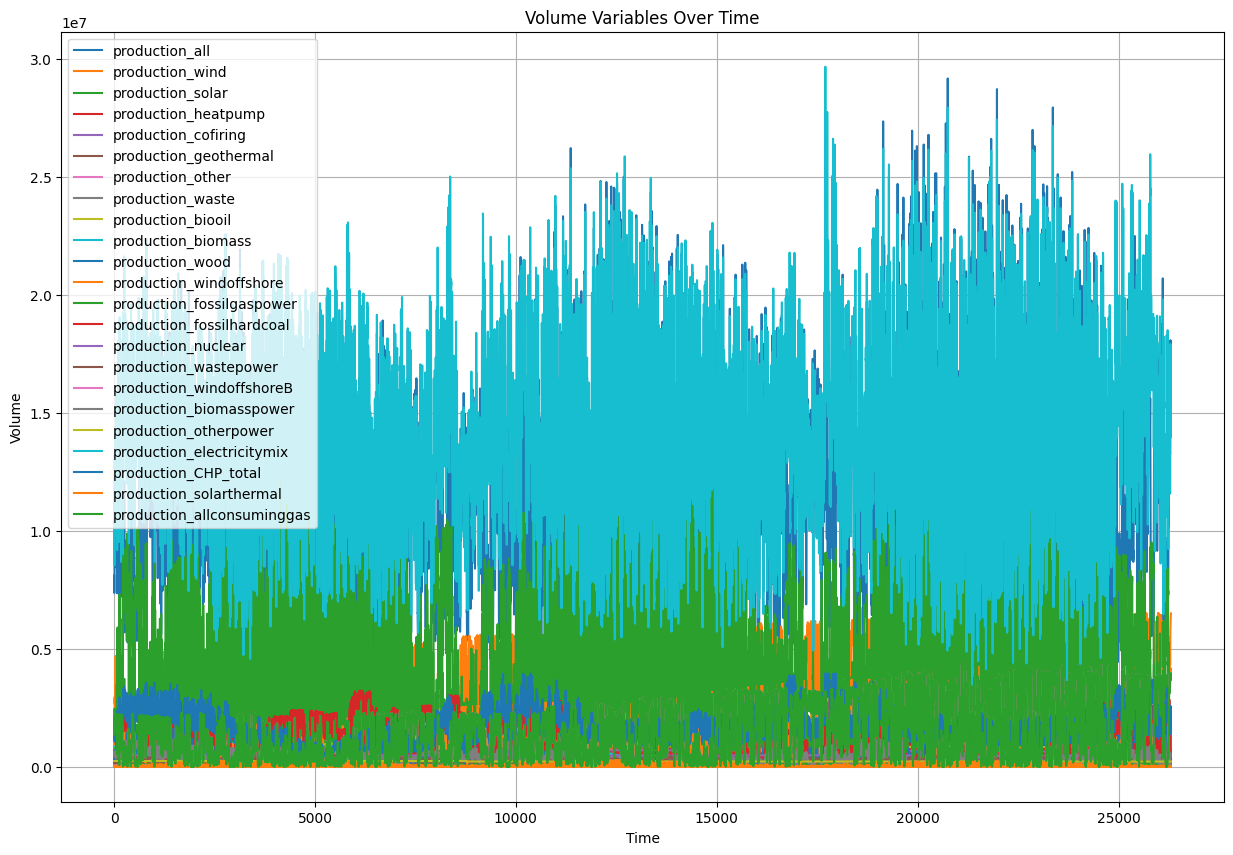

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Select columns that start with "volume"
volume_columns = [
    'production_all',
    'production_wind', 
    'production_solar', 
    'production_heatpump', 
    'production_cofiring', 
    'production_geothermal', 
    'production_other', 
    'production_waste', 
    'production_biooil', 
    'production_biomass', 
    'production_wood', 
    'production_windoffshore', 
    'production_fossilgaspower', 
    'production_fossilhardcoal', 
    'production_nuclear', 
    'production_wastepower', 
    'production_windoffshoreB', 
    'production_biomasspower', 
    'production_otherpower', 
    'production_electricitymix', 
    'production_CHP_total', 
    'production_solarthermal', 
    'production_allconsuminggas'
]

# Filter the DataFrame to include only the volume columns
df_volume = df_filtered[volume_columns]

# Plot the volume columns
plt.figure(figsize=(15, 10))
for col in df_volume.columns:
    plt.plot(df_volume.index, df_volume[col], label=col)

plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Volume Variables Over Time')
plt.legend()
plt.grid(True)
plt.show()

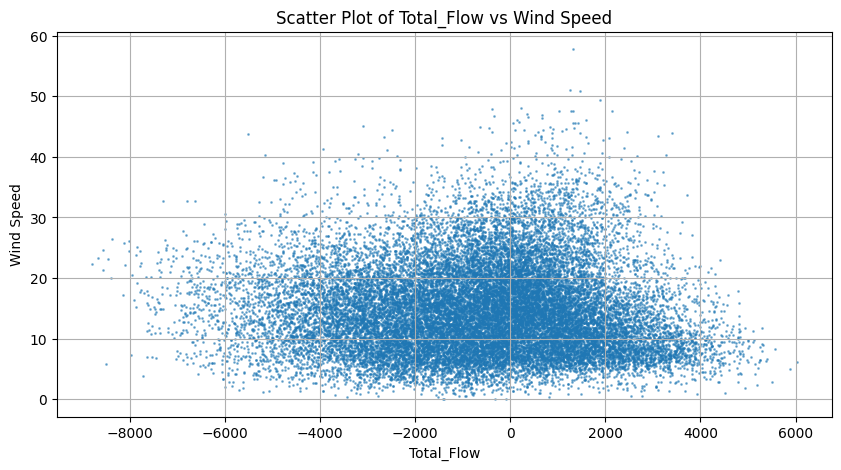

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered['Total_Flow'], df_filtered['wind_speed_10m'], s=1, alpha=0.5)  # Adjust 's' for point size
plt.xlabel('Total_Flow')
plt.ylabel('Wind Speed')
plt.title('Scatter Plot of Total_Flow vs Wind Speed')
plt.grid(True)
plt.show()

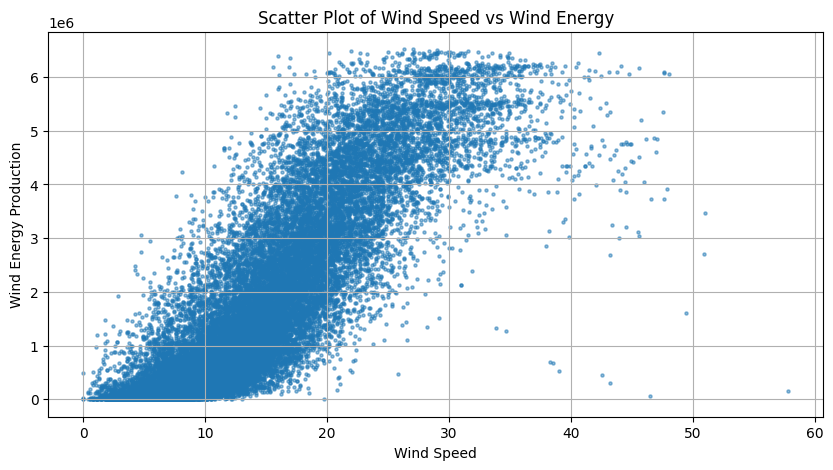

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered['wind_speed_10m'], df_filtered['production_wind'], s=5, alpha=0.5)  # Adjust 's' for point size
plt.xlabel('Wind Speed')
plt.ylabel('Wind Energy Production')
plt.title('Scatter Plot of Wind Speed vs Wind Energy')
plt.grid(True)
plt.show()

In [13]:
import numpy as np

# Drop rows with missing values in 'Price' or 'Load' columns
df_filtered_ws = df_filtered[['production_wind', 'wind_speed_10m']].dropna()

# Calculate the correlation coefficient
r = np.corrcoef(df_filtered_ws['production_wind'], df_filtered_ws['wind_speed_10m'])
print("Correlation coefficient matrix:")
print(r)

Correlation coefficient matrix:
[[1.         0.84936691]
 [0.84936691 1.        ]]


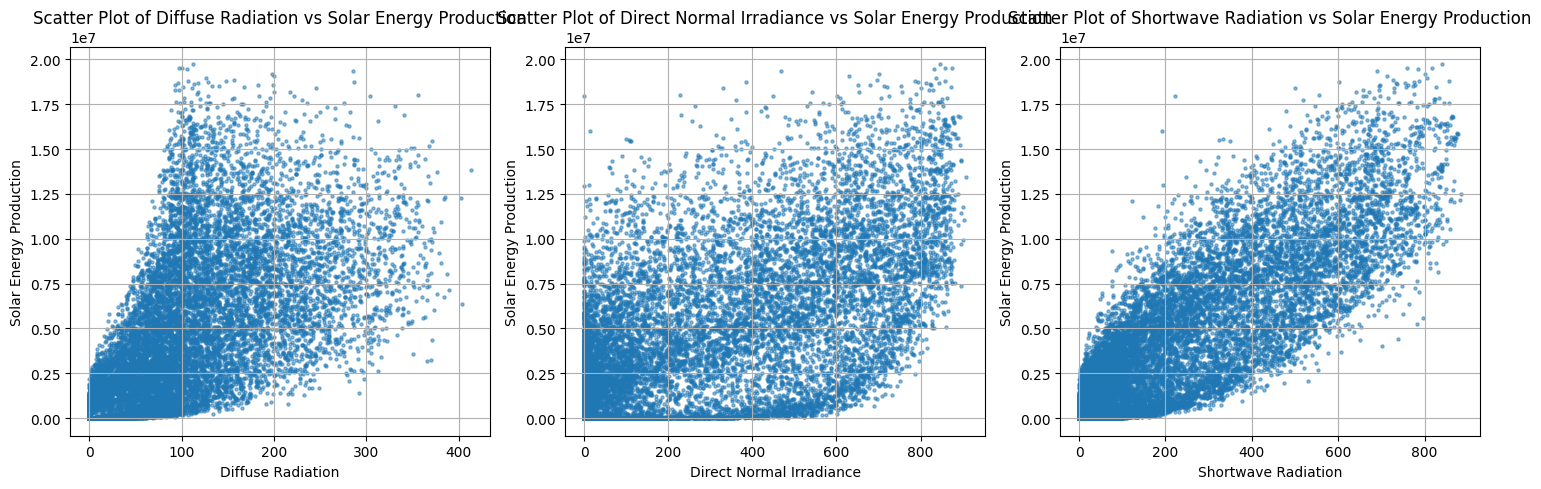

In [14]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for 'diffuse_radiation'
axs[0].scatter(df_filtered['diffuse_radiation'], df_filtered['production_solar'], s=5, alpha=0.5)
axs[0].set_xlabel('Diffuse Radiation')
axs[0].set_ylabel('Solar Energy Production')
axs[0].set_title('Scatter Plot of Diffuse Radiation vs Solar Energy Production')
axs[0].grid(True)

# Scatter plot for 'direct_normal_irradiance'
axs[1].scatter(df_filtered['direct_normal_irradiance'], df_filtered['production_solar'], s=5, alpha=0.5)
axs[1].set_xlabel('Direct Normal Irradiance')
axs[1].set_ylabel('Solar Energy Production')
axs[1].set_title('Scatter Plot of Direct Normal Irradiance vs Solar Energy Production')
axs[1].grid(True)

# Scatter plot for 'shortwave_radiation'
axs[2].scatter(df_filtered['shortwave_radiation'], df_filtered['production_solar'], s=5, alpha=0.5)
axs[2].set_xlabel('Shortwave Radiation')
axs[2].set_ylabel('Solar Energy Production')
axs[2].set_title('Scatter Plot of Shortwave Radiation vs Solar Energy Production')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import plotly.express as px

# Select the desired columns
selected_columns = [
    'Load', 'Price', 'Total_Flow', 'temperature_2m', 'apparent_temperature', 
    'cloud_cover', 'wind_speed_10m', 'diffuse_radiation', 'direct_normal_irradiance', 
    'shortwave_radiation', 'wind_speed_100m', 'location', 'production_wind', 
    'production_solar', 
    'production_heatpump', 
    'production_cofiring', 
    'production_geothermal', 
    'production_other', 
    'production_waste', 
    'production_biooil', 
    'production_biomass', 
    'production_wood', 
    'production_windoffshore', 
    'production_fossilgaspower', 
    'production_fossilhardcoal', 
    'production_nuclear', 
    'production_wastepower', 
    'production_windoffshoreB', 
    'production_biomasspower', 
    'production_otherpower', 
    'production_electricitymix', 
    'production_CHP_total', 
    'production_solarthermal', 
    'production_allconsuminggas'
]

# Filter the DataFrame to include only the selected columns
df_selected = df_filtered[selected_columns]

# Select only the numerical columns
df_numeric = df_selected.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Create an interactive heatmap with Plotly
fig = px.imshow(corr_matrix, 
                labels=dict(color="Correlation"), 
                x=corr_matrix.columns, 
                y=corr_matrix.columns,
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1)

fig.update_layout(title='Correlation Matrix', width=800, height=800)

# Save the figure as an HTML file
fig.write_html("correlation_matrix.html")

# Display a message to the user
print("The interactive correlation matrix has been saved as 'correlation_matrix.html'. Open this file in your browser to view it.")

The interactive correlation matrix has been saved as 'correlation_matrix.html'. Open this file in your browser to view it.


/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_871/443191409.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



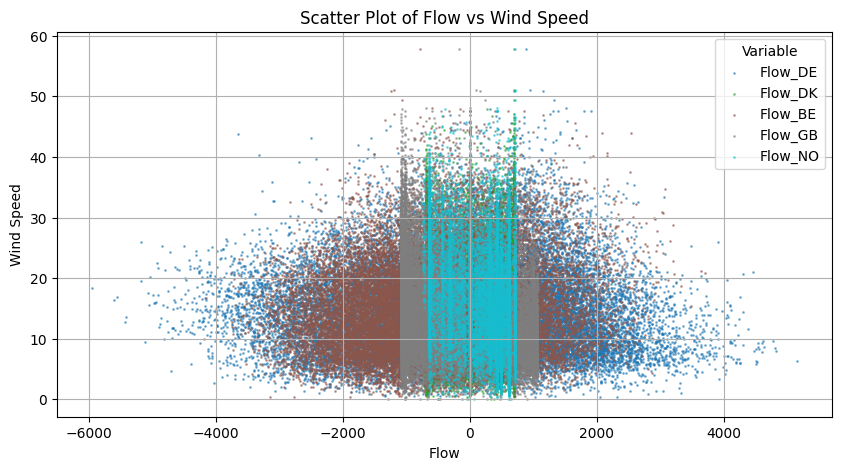

In [16]:
# Define a color map for the variables
colors = plt.cm.get_cmap('tab10', 5)  # Use a colormap with 5 distinct colors

# Plot the scatter plot with different colors for each variable
plt.figure(figsize=(10, 5))
plt.scatter(df_filtered['Flow_DE'], df_filtered['wind_speed_10m'], s=1, alpha=0.5, color=colors(0), label='Flow_DE')
plt.scatter(df_filtered['Flow_DK'], df_filtered['wind_speed_10m'], s=1, alpha=0.5, color=colors(1), label='Flow_DK')
plt.scatter(df_filtered['Flow_BE'], df_filtered['wind_speed_10m'], s=1, alpha=0.5, color=colors(2), label='Flow_BE')
plt.scatter(df_filtered['Flow_GB'], df_filtered['wind_speed_10m'], s=1, alpha=0.5, color=colors(3), label='Flow_GB')
plt.scatter(df_filtered['Flow_NO'], df_filtered['wind_speed_10m'], s=1, alpha=0.5, color=colors(4), label='Flow_NO')

plt.xlabel('Flow')
plt.ylabel('Wind Speed')
plt.title('Scatter Plot of Flow vs Wind Speed')
plt.legend(title='Variable')
plt.grid(True)
plt.show()

In [17]:
nan_totalflow = df_filtered['Total_Flow'].isna().sum()
print(nan_totalflow)
nan_temp = df_filtered['temperature_2m'].isna().sum()
print(nan_temp)
nan_cloud = df_filtered['cloud_cover'].isna().sum()
print(nan_cloud)

3
1
1


Mean Squared Error: 3343.0415359204317
R^2 Score: 0.7388658596232294
                            Coefficient
Load                           0.021537
Total_Flow                    -0.005400
temperature_2m                 9.816530
apparent_temperature          -8.661802
cloud_cover                   -0.060954
wind_speed_10m                -0.318776
diffuse_radiation              0.118306
direct_normal_irradiance       0.101815
shortwave_radiation           -0.278111
wind_speed_100m               -1.694267
production_all                 0.000177
production_wind               -0.000226
production_solar              -0.000231
production_heatpump           -0.000160
production_cofiring           -0.000329
production_geothermal         -0.003317
production_other               0.003548
production_waste               0.002112
production_biooil              0.000069
production_biomass            -0.000664
production_wood               -0.000149
production_windoffshore        0.000001
production_

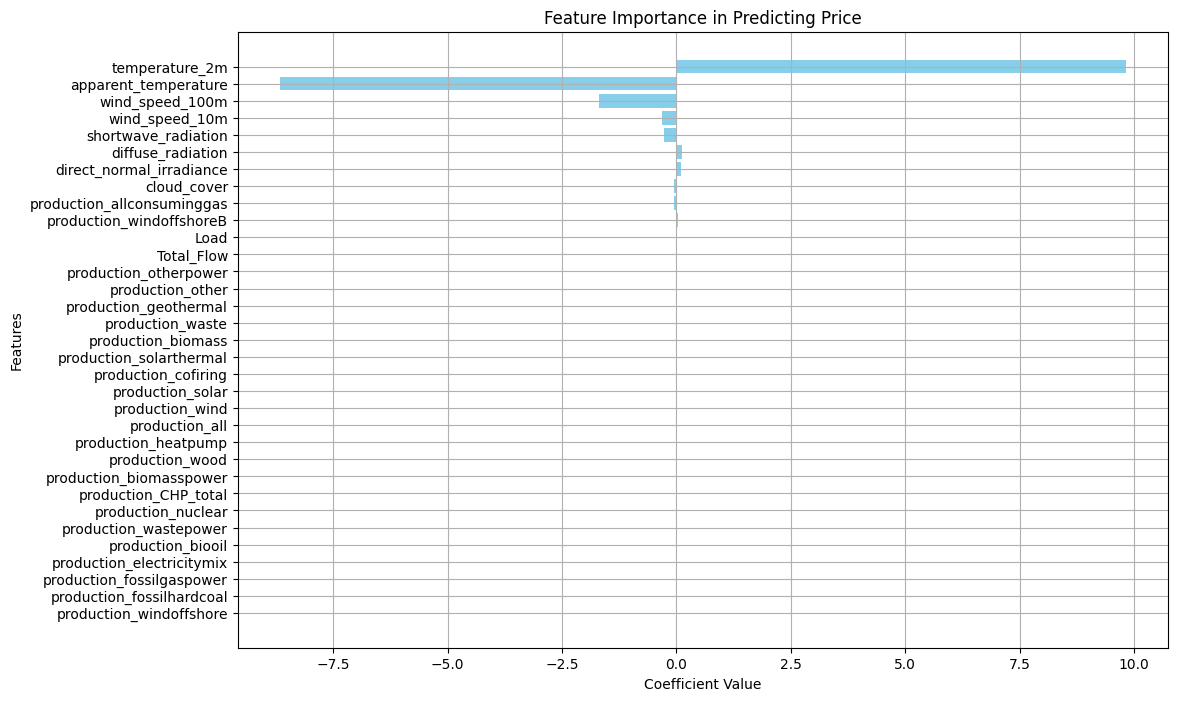

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Drop rows with missing values in the relevant columns
df_filtered_regr = df_filtered[['Price', 'Load', 'Total_Flow', 'temperature_2m', 'apparent_temperature', 'cloud_cover', 'wind_speed_10m', 'diffuse_radiation', 
    'direct_normal_irradiance', 'shortwave_radiation', 'wind_speed_100m', 'production_all', 'production_wind', 'production_solar', 'production_heatpump', 
    'production_cofiring', 'production_geothermal', 'production_other', 'production_waste', 'production_biooil', 'production_biomass', 'production_wood', 
    'production_windoffshore', 'production_fossilgaspower', 'production_fossilhardcoal', 'production_nuclear', 'production_wastepower', 'production_windoffshoreB', 
    'production_biomasspower', 'production_otherpower', 'production_electricitymix', 'production_CHP_total', 'production_solarthermal', 
    'production_allconsuminggas']].dropna()

# Check if the DataFrame is empty
if df_filtered_regr.empty:
    print("The DataFrame is empty after dropping rows with missing values.")
else:
    # Define the features (X) and the target (y)
    X = df_filtered_regr[['Load', 'Total_Flow', 'temperature_2m', 'apparent_temperature', 'cloud_cover', 'wind_speed_10m', 'diffuse_radiation', 'direct_normal_irradiance', 
    'shortwave_radiation', 'wind_speed_100m', 'production_all', 'production_wind', 'production_solar', 'production_heatpump', 'production_cofiring', 'production_geothermal', 
    'production_other', 'production_waste', 'production_biooil', 'production_biomass', 'production_wood', 'production_windoffshore', 'production_fossilgaspower', 
    'production_fossilhardcoal', 'production_nuclear', 'production_wastepower', 'production_windoffshoreB', 'production_biomasspower', 'production_otherpower', 
    'production_electricitymix', 'production_CHP_total', 'production_solarthermal', 'production_allconsuminggas']]
    y = df_filtered_regr['Price']

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions on the same dataset
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    # Get the coefficients of the model
    coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
    print(coefficients)

        # Sort the coefficients by absolute value
    coefficients['abs_coefficient'] = coefficients['Coefficient'].abs()
    coefficients = coefficients.sort_values(by='abs_coefficient', ascending=True)

    # Plot the coefficients
    plt.figure(figsize=(12, 8))
    plt.barh(coefficients.index, coefficients['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.title('Feature Importance in Predicting Price')
    plt.grid(True)
    plt.show()



In [22]:
df_filtered_regr.head

<bound method NDFrame.head of         Price      Load  Total_Flow  temperature_2m  apparent_temperature  \
1      124.70  10249.75      733.50         10.8065              8.505279   
2      134.00   9907.00      388.25         10.5065              7.800850   
3       58.80   9782.50     1065.25         10.2565              7.725925   
4       37.67   9589.75      386.75         10.1565              7.590867   
5       39.70   9508.00      499.25         10.5065              8.126583   
...       ...       ...         ...             ...                   ...   
26299   70.56  15012.00       43.50          5.6565              0.520561   
26300   59.90  14059.25       11.25          6.4565              1.416390   
26301   18.20  13267.50     -466.75          7.2065              2.110953   
26302    9.06  12692.00    -1035.25          7.7065              2.517072   
26303    0.52  12304.75    -1197.00          8.2565              2.992061   

       cloud_cover  wind_speed_10m  diffuse_r